In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numpy import *

In [424]:
#fp = open("/home/hirak/rapmapClustering/sailfish/build/quant_yeast.clust")

In [425]:
s = "1       2735nt, >comp2876_c0_seq2... at +/97.44%"
s.split()[2].lstrip('>').rstrip('.')

'comp2876_c0_seq2'

In [2]:
def readCDHitClust(fn, filtDict=None):
    tr_clust = {}
    tr_clust_inv = {}
    fp = open(fn)
    cnum = None
    for l in fp:
        if l.startswith('>Cluster'):
            cnum = int(l.rstrip().split()[-1])
        else:
            e = l.split()[2].lstrip('>').rstrip('.')
            if not filtDict or e in filtDict:
                tr_clust[e] = cnum
    for k,v in tr_clust.iteritems():
        if v in tr_clust_inv:
            tr_clust_inv[v].append(k)
        else:
            tr_clust_inv[v] = [k]
    return tr_clust, tr_clust_inv

In [3]:
def readCorset(fn):
    ft = open(fn)
    clust_dict = {}
    clust_dict_inv = {}
    for line in ft:
        toks = line.rstrip().split()
        clust_dict[toks[0]] = toks[1]
    for k,v in clust_dict.iteritems():
        if v in clust_dict_inv:
            clust_dict_inv[v].append(k)
        else:
            clust_dict_inv[v] = [k]
    return clust_dict, clust_dict_inv

In [4]:
def readMCLClust(fn):
    fp = open(fn)
    tr_clust = {}
    tr_clust_inv = {}
    key = 1
    for cnum, line in enumerate(fp):
        same_cluster = line.rstrip().split('\t')
        for contig in same_cluster:
            tr_clust[contig] = cnum 
    for k,v in tr_clust.iteritems():
        if v in tr_clust_inv:
            tr_clust_inv[v].append(k)
        else:
            tr_clust_inv[v] = [k]
    return tr_clust, tr_clust_inv

In [5]:
def converMCLClust(fn, ofn):
    fp = open(fn)
    tr_clust = {}
    key = 1
    for cnum, line in enumerate(fp):
        same_cluster = line.rstrip().split('\t')
        for contig in same_cluster:
            tr_clust[contig] = cnum 
    with open(ofn,'w') as ofile:
        for k,v in tr_clust.iteritems():
            ofile.write('{}\t{}\n'.format(k, v))

In [6]:
def readTrueLabels(fn):
    ft = open(fn)
    groundTruth_clust = {}
    groundTruth_clust_inv = {}
    gtClusterCount = {}
    for line in ft:
        tr_gn = line[:-1].split("\t")
        groundTruth_clust[tr_gn[0]] = tr_gn[1]
        if tr_gn[0] in gtClusterCount.keys():
            gtClusterCount[tr_gn[0]] += 1
        else:
            gtClusterCount[tr_gn[0]] = 1
    for k,v in groundTruth_clust.iteritems():
        if v in groundTruth_clust_inv:
            groundTruth_clust_inv[v].append(k)
        else:
            groundTruth_clust_inv[v] = [k]
    return groundTruth_clust, groundTruth_clust_inv

In [ ]:
#count true postive for each pair of transcripts O(N^2)
tp = 0
fp = 0
tn = 0
fn = 0
for tr_1 in groundTruth_clust.keys():
    for tr_2 in groundTruth_clust.keys():
        if tr_1 != tr_2:
            if groundTruth_clust[tr_1] == groundTruth_clust[tr_2]:
                if tr_clust[tr_1] == tr_clust[tr_2]:
                    tp += 1
                else:
                    tn += 1
            else:
                if tr_clust[tr_1] == tr_clust[tr_2]:
                    fp += 1
                else:
                    fn += 1

In [7]:
import itertools

class Classification:
    TruePos, FalsePos, TrueNeg, FalseNeg = range(4)

def classType(true1, true2, pred1, pred2):
    if true1 == true2:
        if pred1 == pred2:
            return Classification.TruePos
        else: # truely the same, predicted different
            return Classification.FalseNeg
    else: # truly different
        if pred1 == pred2: #predicted same
            return Classification.FalsePos
        else:
            return Classification.TrueNeg
        
    
def accuracyExpressed(groundTruth_clust, tr_clust):
    #count true postive for each pair of transcripts O(N^2)
    tp, fp, tn, fn = 0, 0, 0, 0
    for tr_1, tr_2 in itertools.combinations(tr_clust.keys(), 2):
        if tr_1 not in groundTruth_clust or tr_2 not in groundTruth_clust:
            continue
        ct = classType(groundTruth_clust[tr_1], groundTruth_clust[tr_2], tr_clust[tr_1], tr_clust[tr_2]) 
        if ct == Classification.TruePos:
            tp += 1
        elif ct == Classification.TrueNeg:
            tn += 1
        elif ct == Classification.FalsePos:
            fp += 1
        elif ct == Classification.FalseNeg:
            fn += 1
    return tp, fp, tn, fn


def accuracyExpressedFast(groundTruth_clust, groundTruth_clust_inv,
                          tr_clust, tr_clust_inv):
    num = len(set(tr_clust.keys()) & set(groundTruth_clust.keys()))
    tp, fp, tn, fn = 0, 0, 0, 0
    for clustName, clustMems in tr_clust_inv.iteritems():
        for tr_1, tr_2 in itertools.combinations(clustMems,2):
            if tr_1 not in groundTruth_clust or tr_2 not in groundTruth_clust:
                continue
            if groundTruth_clust[tr_1] == groundTruth_clust[tr_2]:
                tp += 1
            else:
                fp += 1
    for clustName, clustMems in groundTruth_clust_inv.iteritems():
        for tr_1, tr_2 in itertools.combinations(clustMems,2):
            if tr_1 not in tr_clust or tr_2 not in tr_clust:
                continue
            if tr_clust[tr_1] != tr_clust[tr_2]:
                fn += 1
    nc2 = (num * (num-1)) / 2
    tn = nc2 - (fp + tp + fn)
    return tp, fp, tn, fn

In [ ]:
converMCLClust("/home/hirak/rapmapClustering/sailfish/build/time_results/quant_human.clust","/home/hirak/rapmapClustering/sailfish/build/time_results/quant_human.clust2")

In [14]:
ft = "/home/hirak/rapmapClustering/sailfish/build/time_results/quant_yeast.clust"
tr_clust, tr_clust_inv = readMCLClust(ft)

In [15]:
ft = "/mnt/scratch3/avi/clustering/yeast/truth/contigs2genes.disambiguous.txt"
groundTruth_clust, ground_truth_clust_inv = readTrueLabels(ft)

In [16]:
tp, fp, tn, fn = accuracyExpressedFast(groundTruth_clust, ground_truth_clust_inv, tr_clust, tr_clust_inv)
print("tp : {}, fp : {}, tn : {}, fn : {}".format(tp, fp, tn, fn))

tp : 468, fp : 840, tn : 2037692, fn : 190


In [17]:
print("prec: {}, recall: {}".format(tp / float(tp + fp), tp / float(tp + fn)))

prec: 0.357798165138, recall: 0.711246200608


In [333]:
tp, fp, tn, fn = accuracyExpressedFast(groundTruth_clust, ground_truth_clust_inv, tr_clust, tr_clust_inv)
print("tp : {}, fp : {}, tn : {}, fn : {}".format(tp, fp, tn, fn))

tp : 453, fp : 30136, tn : 2008396, fn : 205


In [331]:
ft = "/mnt/scratch3/avi/clustering/yeast/truth/contigs2genes.disambiguous.txt"
groundTruth_clust, ground_truth_clust_inv = readTrueLabels(ft)

In [332]:
ft = "/home/hirak/quant_mod_count.clust"
tr_clust, tr_clust_inv = readMCLClust(ft)

In [201]:
ft = "/mnt/scratch3/avi/clustering/yeast/cd_hit/0.8.clstr"
cd_clust = readCDHitClust(ft, filtDict=tr_clust)

In [202]:
tp, fp, tn, fn = accuracyExpressed(groundTruth_clust, cd_clust)
print("tp : {}, fp : {}, tn : {}, fn : {}".format(tp, fp, tn, fn))

tp : 239, fp : 340, tn : 2038192, fn : 419


In [203]:
print("prec: {}, recall: {}".format(tp / float(tp + fp), tp / float(tp + fn)))

prec: 0.412780656304, recall: 0.363221884498


True

In [57]:
len(tr_clust.keys())

7353

In [25]:
"true positive: "+str(tp),"false positive: "+str(fp),"true negative: "+str(tn),"false negative: "+str(fn)

('true positive: 620',
 'false positive: 41626',
 'true negative: 696',
 'false negative: 4035438')

In [26]:
pwd

u'/mnt/scratch1/avi/rapmapAnalysis/data/stats/ipython'

(array([ 3421.,   861.,   622.,   582.,   311.,   311.,   311.,   311.,
          311.,   312.]),
 array([  1.00000000e+00,   3.12000000e+02,   6.23000000e+02,
          9.34000000e+02,   1.24500000e+03,   1.55600000e+03,
          1.86700000e+03,   2.17800000e+03,   2.48900000e+03,
          2.80000000e+03,   3.11100000e+03]),
 <a list of 10 Patch objects>)

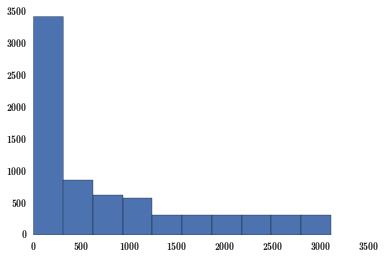

In [28]:
%matplotlib inline
plt.hist(tr_clust.values())

(array([    0.,     0.,     0.,     0.,     0.,  2020.,     0.,     0.,
            0.,     0.]),
 array([ 0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5]),
 <a list of 10 Patch objects>)

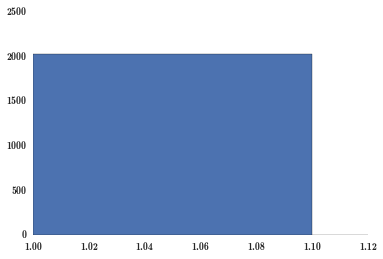

In [30]:
%matplotlib inline
plt.hist(gtClusterCount.values())

In [31]:
import plotly.plotly as py
import plotly.graph_objs as go

ImportError: No module named plotly.plotly

In [313]:
ft = "/home/rob/quant_yeast_mod.clust"
tr_clust_rob = readMCLClust(ft)

In [314]:
tp, fp, tn, fn = accuracyExpressed(groundTruth_clust, tr_clust_rob)
print("tp : {}, fp : {}, tn : {}, fn : {}".format(tp, fp, tn, fn))

tp : 468, fp : 840, tn : 2037692, fn : 190


In [315]:
print("prec: {}, recall: {}".format(tp / float(tp + fp), tp / float(tp + fn)))

prec: 0.357798165138, recall: 0.711246200608


In [310]:
ft = "/mnt/scratch3/avi/clustering/corsetData/Yeast-Trinity/corset-clusters.txt"
corset_clust = readCorset(ft)

In [311]:
tp, fp, tn, fn = accuracyExpressed(groundTruth_clust, corset_clust)
print("tp : {}, fp : {}, tn : {}, fn : {}".format(tp, fp, tn, fn))

tp : 412, fp : 745, tn : 2037787, fn : 246


In [312]:
print("prec: {}, recall: {}".format(tp / float(tp + fp), tp / float(tp + fn)))

prec: 0.356093344857, recall: 0.626139817629


In [354]:
ft_hs = "/mnt/scratch3/avi/clustering/human/truth/contigs2genes.disambiguous.txt"
groundTruth_clust_hs, ground_truth_clust_inv_hs = readTrueLabels(ft_hs)

In [355]:
ft_hs = "/home/rob/quant_human_mod.clust"
tr_clust_hs, tr_clust_inv_hs = readMCLClust(ft_hs)

In [356]:
tp, fp, tn, fn = accuracyExpressedFast(groundTruth_clust_hs, ground_truth_clust_inv_hs, tr_clust_hs, tr_clust_inv_hs)
print("tp : {}, fp : {}, tn : {}, fn : {}".format(tp, fp, tn, fn))

tp : 94896, fp : 5189, tn : 958291019, fn : 62549


In [357]:
print("prec: {}, recall: {}".format(tp / float(tp + fp), tp / float(tp + fn)))

prec: 0.948154069041, recall: 0.602724761028


In [18]:
s = '/home/hirak/rapmapClustering/sailfish/build/oases_data/oases_yeast/quant.net'
import pandas as pd
d = pd.read_table(s)

In [21]:
d = d.convert_objects(convert_numeric=True)

In [24]:
v = np.array(d.ix[:,2])

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

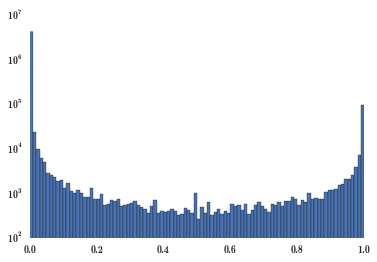

In [30]:
_ = plt.hist(v, bins=100, log=True)